Kepler-427 has 10 LCs and 4 flares that all rather look like flukes.

Kepler-75 has 18 LCs and 5 candidates of which maybe 2 are real.

Kepler-78 is a USP but only 2 LCs and no flares

Kepler-1656 has 13 LCs, 3 candidates, all rather un-flary.

Kepler-432 has 23 LCs, 3 canditates, one looks real.

Kepler-419 has 25 LCs, 

Kepler-444 has 13 LCs, 6 candidates in one of them, likely not real...

HAT-P-2 b may be good but stellar type is F8 and not a young one http://exoplanet.eu/catalog/hat-p-2_b/ doesn't look very active in [Lewis et al. 2013](https://ui.adsabs.harvard.edu/link_gateway/2013ApJ...766...95L/doi:10.1088/0004-637X/766/2/95)

KOI-55 is an USP with 41 LCs, two of which are from TESS, but the star is 27kK degrees hot... 6 candidates, 3 look like flares.

**Kepler-42** is a three-planet systemt around a mid-to-late M dwarf, it has 28 LCs with 2 from TESS, but it is faint (16th mag), but it has 15-20 believable flares.

Kepler-70 also has an M dwarf host, 41 LCs, but only shows the same false positives as KOI-55, it actually spits out the same LCs, because it is the same target. not an M dwarf but a post-RGB star...

Kepler-1520 is disintegrating planet around a mid K dwarf, 14 LCs, 3 candidates, all false positives



##### <0.1 AU, period < 1day , Spt K5-M3 in K2:

K2-137 
EPIC 213715787
K2-22
EPIC 248435473 


In [10]:
from astroquery.mast import Observations
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
obs_table = Observations.query_criteria(obs_collection=['Kepler'],
                                        objectname="Kepler 12",
                                        dataproduct_type="timeseries",
                                        radius=0)

In [3]:
obs_table

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID,objID1,distance
str10,int64,str6,str36,str13,float64,float64,float64,float64,float64,str7,str6,float64,float64,str1,str18,float64,str6,str15,str2,str6,str6,int64,str6,str112,str109,str108,str6,bool,float64,str7,str10,str10,str10,float64
timeseries,2,Kepler,kplr011804465_lc_Q111111110111011101,kplr011804465,286.24343,50.04038,54953.0375,56423.50069444445,1800.0,OPTICAL,KEPLER,418400000000.0,905000000000.0,--,Kepler Key Project,--,Kepler,William Borucki,EX,Kepler,Kepler,--,Kepler,POLYGON ICRS 286.23997011 50.04260200 286.23997044 50.03815800 286.24688956 50.03815800 286.24688989 50.04260200,http://archive.stsci.edu/missions/kepler/previews/0118/011804465/kplr011804465-2013011073258_llc_bw_large.png,http://archive.stsci.edu/missions/kepler/lightcurves/0118/011804465/kplr011804465_lc_Q111111110111011101.tar,PUBLIC,--,5885.0,science,9000185756,9000199584,9000199584,0.0
timeseries,2,Kepler,kplr011804465_sc_Q003313330333000000,kplr011804465,286.24343,50.04038,54953.0375,56423.50069444445,60.0,OPTICAL,KEPLER,418400000000.0,905000000000.0,--,Kepler Key Project,--,Kepler,William Borucki,EX,Kepler,Kepler,--,Kepler,POLYGON ICRS 286.23997011 50.04260200 286.23997044 50.03815800 286.24688956 50.03815800 286.24688989 50.04260200,http://archive.stsci.edu/missions/kepler/previews/0118/011804465/kplr011804465-2011303113607_slc_bw_large.png,http://archive.stsci.edu/missions/kepler/lightcurves/0118/011804465/kplr011804465_sc_Q003313330333000000.tar,PUBLIC,--,5885.0,science,9000208864,9000199585,9000199585,0.0


In [44]:
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
from astropy.constants import R_jup
import astropy.units as u


In [45]:
eat = NasaExoplanetArchive.get_confirmed_planets_table()

/home/ekaterina/Documents/001_Science/Flares_in_Clusters_II/flaresinclustersii/lib/python3.6/site-packages/astroquery/nasa_exoplanet_archive/nasa_exoplanet_archive.py:95: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/ekaterina/Documents/001_Science/Flares_in_Clusters_II/flaresinclustersii/lib/python3.6/site-packages/astroquery/nasa_exoplanet_archive/data/exoplanet_nexsci_units.json' mode='r' encoding='UTF-8'>
  if col in self.param_units:


In [61]:
#Look for HJs
eat[(eat["pl_radj"]>.25 * R_jup) & 
    (eat["pl_orbeccen"]>.5) & 
    (eat["pl_orbper"]<60 * u.d) &
    (eat["pl_kepflag"]==1)
   ]

pl_hostname,pl_letter,pl_name,pl_discmethod,pl_controvflag,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbpern,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbsmaxlim,pl_orbsmaxn,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbeccenlim,pl_orbeccenn,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_orbincllim,pl_orbincln,pl_bmassj,pl_bmassjerr1,pl_bmassjerr2,pl_bmassjlim,pl_bmassn,pl_bmassprov,pl_radj,pl_radjerr1,pl_radjerr2,pl_radjlim,pl_radn,pl_dens,pl_denserr1,pl_denserr2,pl_denslim,pl_densn,pl_ttvflag,pl_kepflag,pl_k2flag,ra_str,dec_str,ra,st_raerr,dec,st_decerr,st_posn,st_dist,st_disterr1,st_disterr2,st_distlim,st_distn,st_optmag,st_optmagerr,st_optmaglim,st_optband,gaia_gmag,gaia_gmagerr,gaia_gmaglim,st_teff,st_tefferr1,st_tefferr2,st_tefflim,st_teffn,st_mass,st_masserr1,st_masserr2,st_masslim,st_massn,st_rad,st_raderr1,st_raderr2,st_radlim,st_radn,pl_nnotes,rowupdate,pl_facility,NAME_LOWERCASE,sky_coord
,,,,,,d,d,d,d,,AU,AU,AU,AU,,,,,,,deg,deg,deg,deg,,jupiterMass,jupiterMass,jupiterMass,jupiterMass,,,jupiterRad,jupiterRad,jupiterRad,jupiterRad,,,,,,,,,,,,deg,,deg,,,pc,pc,pc,pc,,mag,mag,mag,,,,,K,K,K,K,,solMass,solMass,solMass,solMass,,solRad,solRad,solRad,solRad,,,,,,"deg,deg"
str27,str1,str29,str29,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,str14,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,int64,int64,str14,str15,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,str11,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,str10,str44,str26,object
Kepler-75,b,Kepler-75 b,Transit,0,1,8.8849116,3.4e-06,-3.4e-06,0.0,6,0.0818,0.0012,-0.0012,0.0,3,0.57,0.01,-0.01,0,3,89.12,0.51,-0.64,0.0,3,10.1,0.4,-0.4,0.0,3,Mass,1.05,0.03,-0.03,0.0,5,11.0,0.8,-0.9,0,3,0,1,0,19h24m33.02s,+36d34m38.6s,291.137593,1.9e-05,36.577386,1.7e-05,2,855.5,19.1,-19.1,0.0,4,15.264,0.0,0.0,Kepler-band,15.179,--,0,5200.0,100.0,-100.0,0.0,8,0.91,0.04,-0.04,0.0,4,0.89,0.02,-0.02,0.0,8,1,2015-01-29,Kepler,kepler-75b,"291.137593,36.577386"
Kepler-427,b,Kepler-427 b,Transit,0,1,10.290994,1.1e-06,-1.1e-06,0.0,5,0.091,0.01,-0.01,0.0,2,0.57,--,--,1,2,89.5,0.45,-0.45,0.0,2,0.29,0.09,-0.09,0.0,2,Mass,1.23,0.21,-0.21,0.0,4,0.16,0.14,-0.14,0,2,0,1,0,19h13m01.10s,+43d42m17.5s,288.25458,1.7e-05,43.704868,1.7e-05,2,1100.0,150.0,-150.0,0.0,4,14.42,0.02,0.0,V (Johnson),14.196,--,0,5800.0,70.0,-70.0,0.0,7,0.96,0.06,-0.06,0.0,3,1.35,0.2,-0.2,0.0,7,1,2014-10-03,Kepler,kepler-427b,"288.25458,43.704868"
Kepler-432,b,Kepler-432 b,Transit,0,2,52.501129,6.7e-05,-5.3e-05,0.0,6,0.301,0.016,-0.011,0.0,3,0.5134,0.0098,-0.0089,0,3,88.17,0.61,-0.33,0.0,3,5.41,0.32,-0.18,0.0,3,Mass,1.145,0.036,-0.039,0.0,5,4.46,0.37,-0.29,0,3,0,1,0,19h33m07.73s,+48d17m09.2s,293.282206,1.9e-05,48.2859,1.9e-05,2,870.0,20.0,-20.0,0.0,3,12.465,0.06,0.0,V (Johnson),12.182,--,0,4995.0,78.0,-78.0,0.0,7,1.32,0.1,-0.07,0.0,3,4.06,0.12,-0.08,0.0,7,1,2015-04-30,Kepler,kepler-432b,"293.282206,48.2859"
KOI-12,b,KOI-12 b,Transit,0,1,17.85523,1e-06,-1e-06,0.0,5,0.0,0.0,0.0,0.0,1,0.72,--,--,0,2,88.95,0.2,-0.2,0.0,2,5.32,6.11,-6.11,0.0,2,Mass,1.54,0.45,-0.45,0.0,4,--,--,--,0,0,0,1,0,19h49m48.90s,+41d00m39.6s,297.453731,1.7e-05,41.010991,1.7e-05,2,403.99,4.42,-4.42,0.0,4,11.353,0.0,0.0,Kepler-band,11.253,--,0,6820.0,120.0,-120.0,0.0,7,1.82,1.64,-1.64,0.0,3,1.75,0.51,-0.51,0.0,7,1,2018-04-26,Kepler,koi-12b,"297.453731,41.010991"
Kepler-1656,b,Kepler-1656 b,Transit,0,1,31.578659,0.0,0.0,0.0,2,0.197,0.021,-0.021,0.0,1,0.836,0.013,-0.012,0,1,89.31,0.47,-0.51,0.0,1,0.15291,0.01321,-0.01196,0.0,1,Mass,0.448,0.047,-0.047,0.0,1,2.13,0.87,-0.57,0,1,0,1,0,18h57m53.32s,+39d54m42.6s,284.472168,1.9e-05,39.911824,1.7e-05,2,186.88,0.83,-0.83,0.0,1,11.64,0.13,0.0,V (Johnson),11.062,--,0,5731.0,60.0,-60

In [56]:
eat[
    (eat["pl_orbper"]<.5 * u.d) &
    (eat["pl_kepflag"]==1)&
    (eat["pl_letter"]=="b")
   ]

pl_hostname,pl_letter,pl_name,pl_discmethod,pl_controvflag,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbpern,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbsmaxlim,pl_orbsmaxn,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbeccenlim,pl_orbeccenn,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_orbincllim,pl_orbincln,pl_bmassj,pl_bmassjerr1,pl_bmassjerr2,pl_bmassjlim,pl_bmassn,pl_bmassprov,pl_radj,pl_radjerr1,pl_radjerr2,pl_radjlim,pl_radn,pl_dens,pl_denserr1,pl_denserr2,pl_denslim,pl_densn,pl_ttvflag,pl_kepflag,pl_k2flag,ra_str,dec_str,ra,st_raerr,dec,st_decerr,st_posn,st_dist,st_disterr1,st_disterr2,st_distlim,st_distn,st_optmag,st_optmagerr,st_optmaglim,st_optband,gaia_gmag,gaia_gmagerr,gaia_gmaglim,st_teff,st_tefferr1,st_tefferr2,st_tefflim,st_teffn,st_mass,st_masserr1,st_masserr2,st_masslim,st_massn,st_rad,st_raderr1,st_raderr2,st_radlim,st_radn,pl_nnotes,rowupdate,pl_facility,NAME_LOWERCASE,sky_coord
,,,,,,d,d,d,d,,AU,AU,AU,AU,,,,,,,deg,deg,deg,deg,,jupiterMass,jupiterMass,jupiterMass,jupiterMass,,,jupiterRad,jupiterRad,jupiterRad,jupiterRad,,,,,,,,,,,,deg,,deg,,,pc,pc,pc,pc,,mag,mag,mag,,,,,K,K,K,K,,solMass,solMass,solMass,solMass,,solRad,solRad,solRad,solRad,,,,,,"deg,deg"
str27,str1,str29,str29,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,str14,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,int64,int64,str14,str15,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,str11,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,str10,str44,str26,object
Kepler-78,b,Kepler-78 b,Transit,0,1,0.35500744,6e-08,-6e-08,0.0,7,0.0,0.0,0.0,0.0,0,--,--,--,0,2,79.0,12.5,-12.5,0.0,3,0.01,0.0,0.0,0.0,6,Mass,0.1,0.01,-0.01,0.0,6,--,--,--,0,4,0,1,0,19h34m58.01s,+44d26m54.0s,293.74169,1.7e-05,44.44833,1.7e-05,2,124.82,0.33,-0.33,0.0,2,11.551,0.0,0.0,Kepler-band,11.529,--,0,5089.0,50.0,-50.0,0.0,8,0.84,0.32,-0.32,0.0,6,0.75,0.03,-0.03,0.0,8,2,2018-12-06,Kepler,kepler-78b,"293.74169,44.44833"
KOI-55,b,KOI-55 b,Orbital Brightness Modulation,0,2,0.240104,4e-06,-4e-06,0.0,1,0.006,0.0,0.0,0.0,1,--,--,--,--,0,65.0,0.0,0.0,0.0,1,0.0014,0.0,0.0,0.0,1,Mass,0.068,0.0,0.0,0.0,1,--,--,--,--,0,0,1,0,19h45m25.47s,+41d05m33.9s,296.356105,3.9e-05,41.092755,3.1e-05,2,1180.0,95.0,-95.0,0.0,2,14.87,0.02,0.0,V (Johnson),14.906,--,0,27730.0,270.0,-270.0,0.0,3,0.5,0.0,-0.0,0.0,1,0.2,0.01,-0.01,0.0,2,0,2014-05-14,Kepler,koi-55b,"296.356105,41.092755"
KIC 10001893,b,KIC 10001893 b,Orbital Brightness Modulation,1,3,0.2197,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0,--,--,--,--,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,--,0.0,0.0,0.0,0.0,0,--,--,--,--,0,0,1,0,19h09m33.41s,+46d59m04.2s,287.389188,3.6e-05,46.984489,3.3e-05,2,1758.47,161.58,-161.58,0.0,1,15.846,0.0,0.0,Kepler-band,15.711,--,0,27500.0,200.0,-500.0,0.0,3,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,1,2014-10-03,Kepler,kic10001893b,"287.389188,46.984489"


In [2]:
from lightkurve import search_lightcurvefile, LightCurveCollection
from altaipony.flarelc import FlareLightCurve
from altaipony.altai import find_iterative_median

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
import numpy as np

In [239]:
lclist = search_lightcurvefile("K2-137", cadence="long",)
lclist# 305807616-2009259162342_slc.fits

SearchResult containing 1 data products.

 target_name        productFilename                    description              distance
------------- --------------------------- ------------------------------------- --------
ktwo228813918 ktwo228813918-c102_llc.fits Lightcurve Long Cadence (KLC) - C10-2      0.0

In [227]:
lcs = lclist.download_all()

1% (563/47370) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (563/47370) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (448/42930) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (448/42930) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (867/39990) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
2% (867/39990) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
19% (8480/45330) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
19% (8480/45330) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (106/44280) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (106/44280) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (161/50160) o

In [228]:
lcc = [x.get_lightcurve("PDCSAP_FLUX") for x in lcs]
LCC = [FlareLightCurve(time=LC.time, flux=LC.flux, flux_err=LC.flux_err, cadenceno=LC.cadenceno) for LC in lcc]

In [229]:
for LC in LCC:
    fll = LC.detrend("savgol")
    fll.detrended_flux_err[:] = fll.detrended_flux.std()
    flares = fll.find_flares().flares
    with open("res.csv", "a") as f:
        flares.to_csv(f, index=False)

Found 0 candidate(s) in the (0,46806) gap.
Found 1 candidate(s) in the (0,42289) gap.
/home/ekaterina/Documents/001_Science/Flares_in_Clusters_II/flaresinclustersii/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
Found 0 candidate(s) in the (0,33465) gap.
Found 0 candidate(s) in the (33465,39122) gap.
Found 0 candidate(s) in the (0,22222) gap.
Found 0 candidate(s) in the (22222,34813) gap.
Found 1 candidate(s) in the (0,44151) gap.
Found 1 candidate(s) in the (0,49958) gap.
Found 0 candidate(s) in the (0,44875) gap.
Found 0 candidate(s) in the (0,10870) gap.
Found 0 candidate(s) in the (10870,35656) gap.
Found 0 candidate(s) in the (0,51069) gap.
Found 0 candidate(s) in the (0,7622) gap.
Found 0 candidate(s) in

In [236]:
flcd = LCC[5].detrend("savgol")

(1337, 1338)

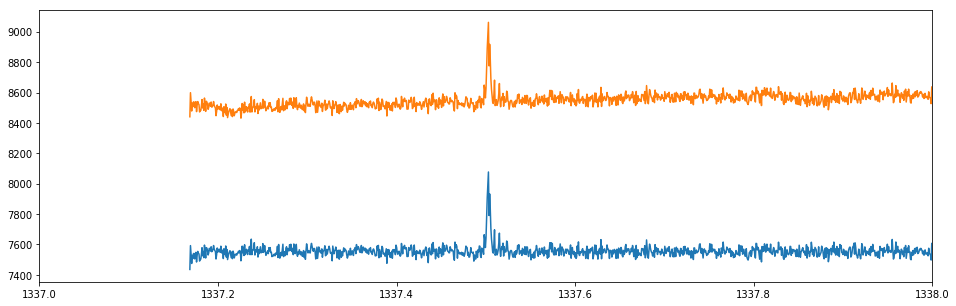

In [237]:
plt.figure(figsize=(16,5))
plt.plot(flcd.time, flcd.detrended_flux)
plt.plot(flcd.time, flcd.flux+1000)

plt.xlim(1337, 1338)
#plt.ylim(13000,14000)

In [7]:
LC = lcc[0]
LC.flux[:] = LC.flux/np.nanmedian(LC.flux)
lcc[-1].flux[:] += lcc[-1].flux + 1.
lcc[-2].flux[:] += lcc[-2].flux + 1.
for lc in lcc[1:]:
    lc.flux = lc.flux/np.nanmedian(lc.flux)
    LC = LC.append(lc)

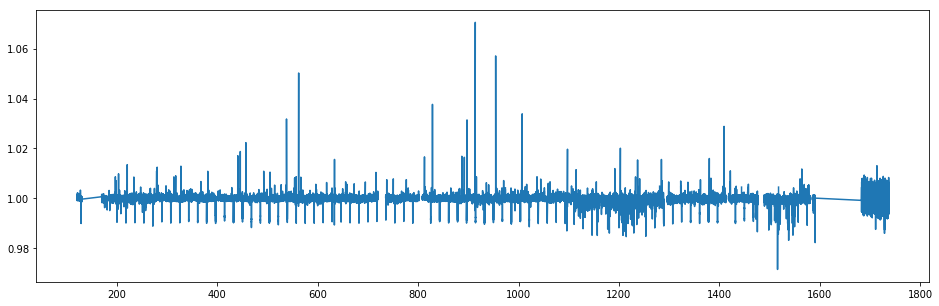

In [8]:
plt.figure(figsize=(16,5))
plt.plot(LC.time, LC.flux)
#plt.xlim(456.8,457)

In [12]:
FLC = FlareLightCurve(time=LC.time, flux=LC.flux, flux_err=LC.flux_err)

In [13]:
FLCd = FLC.detrend("savgol", window_length=15)

In [18]:
itmed = find_iterative_median(FLCd)

In [21]:
FLCd.detrended_flux

array([1.0000887 , 0.99997795, 1.0001796 , ..., 1.0047519 , 1.0013777 ,
       0.9994352 ], dtype=float32)

In [240]:
from altaipony.lcio import from_mast

In [247]:
flc = from_mast("228813918", cadence="long", mission="K2", mode="TPF", c=10)

/home/ekaterina/Documents/001_Science/Flares_in_Clusters_II/flaresinclustersii/lib/python3.6/site-packages/lightkurve/search.py:181: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)
1% (4/306) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (4/306) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


/home/ekaterina/Documents/001_Science/Flares_in_Clusters_II/flaresinclustersii/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


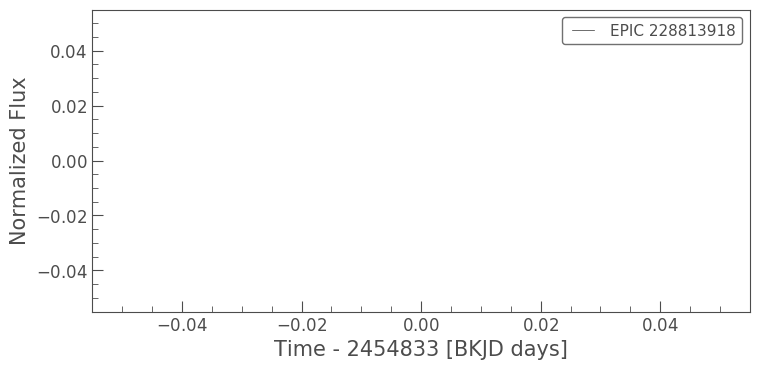

In [248]:
flc.plot()

In [252]:
flc.campaign = None
flcd = flc.detrend("k2sc", splits=[])

Using split values [300] given from the command line


ValueError: Range cannot be empty (low >= high) unless no samples are taken

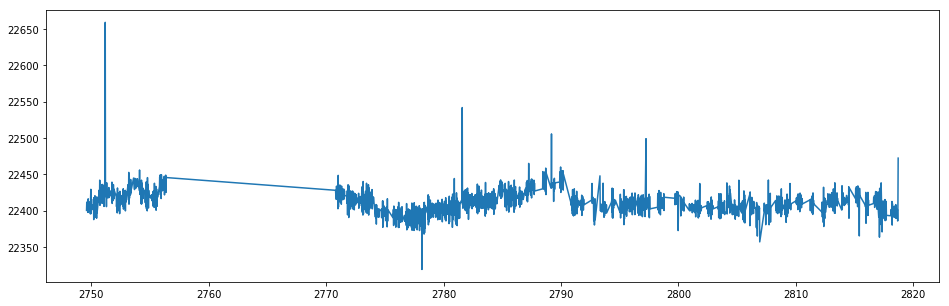

In [245]:
plt.figure(figsize=(16,5))
plt.plot(flcd.time, flcd.detrended_flux)
#plt.xlim(382, 383);

In [102]:
flcd.find_flares().flares


Found 1 candidate(s) in the (0,45419) gap.
/home/ekaterina/Documents/001_Science/Flares_in_Clusters_II/flaresinclustersii/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,ampl_rec,cstart,cstop,ed_rec,ed_rec_err,istart,istop,total_n_valid_data_points,tstart,tstop
0,0.00332,390671,390676,0.59554,0.027952,44624,44629,45419.0,382.873989,382.877394
